## 2024 Reinforcement Learning @ KHU

DQN
---

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/DQN
!ls
import sys; sys.path.append('..') # add project root to the python path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/RL/DQN
 A2C.ipynb	   actor10450.pt   actor9250.pt    CarRacing-v2     critic8450.pt   critic_best.pt
'A2C(sub).ipynb'   actor8050.pt    actor9650.pt    critic10050.pt   critic8850.pt   critic.pt
 actor		   actor8450.pt    actor_best.pt   critic10450.pt   critic9250.pt   log.txt
 actor10050.pt	   actor8850.pt    actor.pt	   critic8050.pt    critic9650.pt   wandb


Car Racing

https://gymnasium.farama.org/environments/box2d/car_racing/


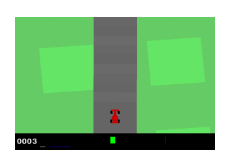

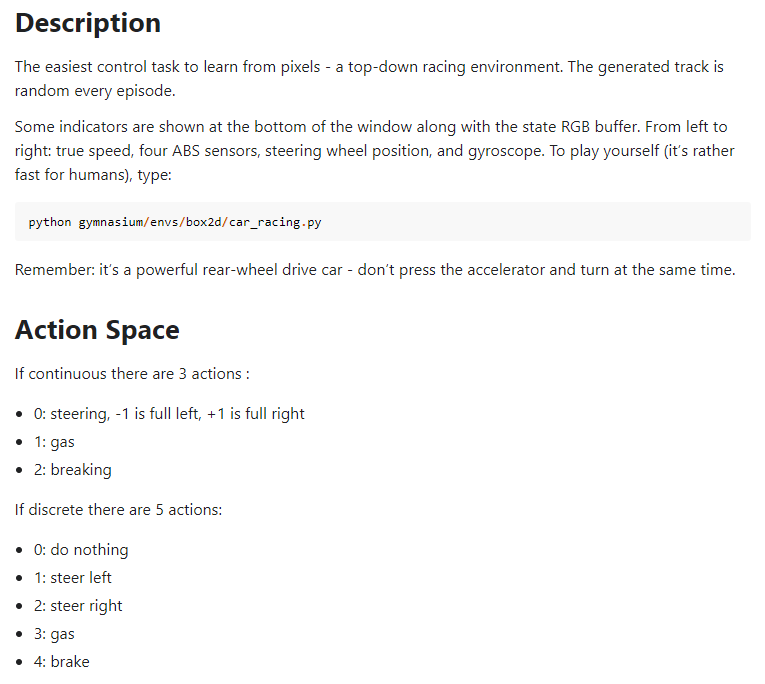

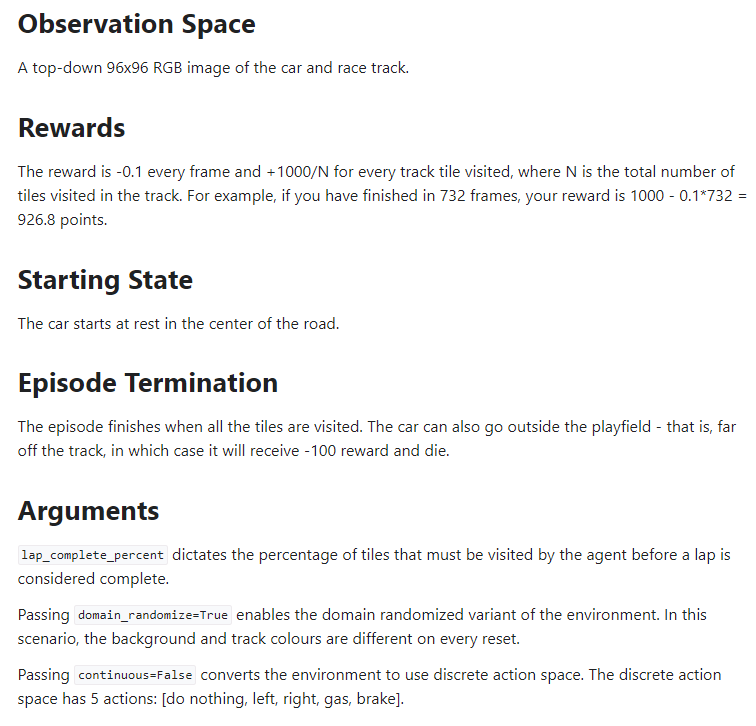

In [4]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

In [4]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


## Check the Video

In [6]:
env.reset()
frames = []
# 50 frame은 도입부라서 학습에 사용되지 않음 > PASS
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

NameError: name 'env' is not defined

# Preprocess the Image

In [7]:
# Every frme always contains a black area at the bottom of the frame, so we had better cut this black area.
# Also, Color imformation is not directly related to car racing. So we will use gray image for computation efficiency.
# 학습에 불필요한 부분은 CROP 후에 사용함 (Grayscale로 변환)
def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

# Manual Environment

In [8]:
class ImageEnv(gym.Wrapper):

# skip_frame: 한번 action을 수행하면 4frame동안 진행함
# stack_frame: 4프레임을 모아서 한번의 입력으로 제공함
# initial_no_op: 최초 skip 프레임 수

    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    # 처음으로 돌아감

    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        # terminated: 완료 / truncated: 실패
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

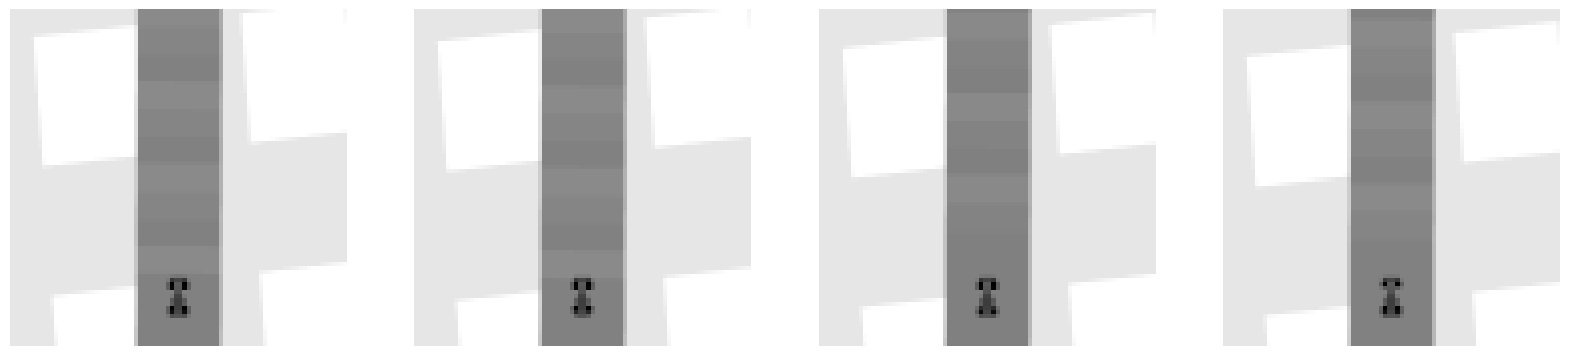

In [11]:
"""
0: do nothing
1: steer left
2: steer right
3: steer gas
4: brake
"""
# 하나의 action이 4개의 frame에 적용되는 예시

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

env.reset()
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # #3 action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Network

In [12]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.conv1=nn.Conv2d(state_dim[0],16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.in_features=32*9*9
        self.fc1=nn.Linear(self.in_features,256)
        self.fc2=nn.Linear(256,action_dim)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       x = F.relu(self.conv2(x))
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = self.fc2(x)
       x = F.softmax(x, dim=-1)
       return x

# In critics, Q(s,a) is input and the value is output
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.conv1=nn.Conv2d(state_dim[0],16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.in_features=32*9*9
        self.fc1=nn.Linear(self.in_features + action_dim ,256)
        self.fc2=nn.Linear(256,action_dim)


    def forward(self, state, action):
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.cat([x, action], 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


# Replay Buffer

In [13]:
class ReplayBuffer:

  def __init__(self,state_dim,action_dim,max_size=int(1e5)):
    self.s=np.zeros((max_size,*state_dim),dtype=np.float32)
    self.a=np.zeros((max_size,*action_dim),dtype=np.int64)
    self.r=np.zeros((max_size,1),dtype=np.float32)
    self.ns=np.zeros((max_size,*state_dim),dtype=np.float32)
    self.done=np.zeros((max_size,1),dtype=np.float32)


    self.ptr=0
    self.size=0
    self.max_size=max_size

  def update(self, s, a, r, ns, done):
      self.s[self.ptr] = s
      self.a[self.ptr] = a
      self.r[self.ptr] = r
      self.ns[self.ptr] = ns
      self.done[self.ptr] = done

      self.ptr = (self.ptr + 1) % self.max_size
      self.size = min(self.size + 1, self.max_size)

  def sample(self, batch_size):
      ind = np.random.randint(0, self.size, batch_size)
      return (
          torch.FloatTensor(self.s[ind]),
          torch.FloatTensor(self.a[ind]),
          torch.FloatTensor(self.r[ind]),
          torch.FloatTensor(self.ns[ind]),
          torch.FloatTensor(self.done[ind]),
      )

# OU noise

In [14]:

import random
import copy

class OUNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

In [15]:
class DDPG:
    def __init__(
            self,
            state_dim,
            action_dim,
            lr=0.0001,
            gamma=0.99,
            batch_size=64,
            warmup_steps=10000,
            warmup_bool = True,
            update_steps=1000,
            tau=5e-3,
            buffer_size=int(1e5)
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.warmup_bool = warmup_bool
        self.update_steps = update_steps
        self.tau = tau
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.actor = Actor(state_dim, action_dim).to(self.device)
        self.critic = Critic(state_dim, action_dim).to(self.device)

        self.actor_target = Actor(state_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target = Critic(state_dim, action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (action_dim,), buffer_size)

        self.total_steps = 0
        self.episode_steps = 0

    def select_action(self, x, training=True):
        x = np.array(x)  # 만약 x가 리스트 형태라면 numpy 배열로 변환
        x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs = self.actor(x).cpu().numpy().flatten()  # Actor 네트워크의 출력이 확률 분포
            # print({'action_probs': probs})


        if training:
          # 노이즈를 추가하여 탐험을 증가
          noise = np.random.normal(0, 0.1, size=probs.shape)
          noisy_probs = probs + noise
          noisy_probs = np.clip(noisy_probs, 0, 1)  # 확률 값은 0과 1 사이로 클리핑
          noisy_probs = noisy_probs / np.sum(noisy_probs)  # 확률 분포가 되도록 정규화
          a = np.random.choice(len(noisy_probs), p=noisy_probs)  # 노이즈가 추가된 확률 분포에 따라 액션 선택
        else:
          a = np.random.choice(len(probs), p=probs)  # 최대 확률을 가진 액션 선택
        # print({"eval_action": a})
        return a

    def update_model(self):
        s, a, r, ns, done = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))
        na = self.actor_target(ns)
        next_value = self.critic_target(ns, na)
        td_target = r + self.gamma * (1 - done) * next_value

        # Critic Optimization
        values = self.critic(s, a)
        critic_loss = F.mse_loss(values, td_target)
        # print({"critic_loss": critic_loss})

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor Optimization
        actor_loss = -self.critic(s, self.actor(s)).mean()
        # print({"actor_loss": actor_loss})

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Target update
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def process(self, transition):
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.warmup_bool and self.total_steps > self.warmup_steps:
            self.update_model()
            self.warmup_bool = False

        if not (self.warmup_bool) and self. total_steps > self.update_steps:
          self.update_model()

# Training

In [16]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(1e6)
eval_interval = 100
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DDPG(state_dim, action_dim)

In [17]:
def evaluate(n_evals=1):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)

    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.select_action(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
            # print({"ret":ret})
        scores += ret
    return np.round(scores / n_evals, 4)

In [36]:
# !pip install wandb

In [37]:
import wandb

Training!!

In [38]:
wandb.init(project='RL_DDPG')
wandb.run.name = 'RL_DDPG_buffer'
wandb.run.save()

history = {'Step': [], 'AvgReturn': []}
(s,_)=env.reset()
episode_steps = 0
total_rewards = []
while True:
  a=agent.select_action(s)
  ns, r, done, truncated, info = env.step(a)
  # Update
  agent.process((s, a, r, ns, done))
  # episode_steps += 1

  s=ns

  if done or truncated:
    (s,_)=env.reset()
    # print(episode_steps)
    # episode_steps = 0

  if agent.total_steps % eval_interval == 0:
    rewards = evaluate()
    if not total_rewards or (rewards > max(total_rewards)):
      torch.save(agent.actor.state_dict(), 'actor_best.pt')
      torch.save(agent.critic.state_dict(), 'critic_best.pt')
    wandb.log({'AvgReturn': rewards})
    total_rewards.append(rewards)
    print({'rewards': rewards})
    history['Step'].append(agent.total_steps)
    history['AvgReturn'].append(rewards)

    # clear_output()
    # plt.figure(figsize=(8, 5))
    # plt.plot(history['Step'], history['AvgReturn'], 'r-')
    # plt.xlabel('Step', fontsize=16)
    # plt.ylabel('AvgReturn', fontsize=16)
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)
    # plt.grid(axis='y')
    # plt.show()

    torch.save(agent.actor.state_dict(), 'actor.pt', )
    torch.save(agent.critic.state_dict(), 'critic.pt')


  if agent.total_steps > max_steps:
    break

AvgReturn,▁
AvgReturn,-36.7808


{'rewards': -53.457}
{'rewards': -38.3962}
{'rewards': -75.8307}
{'rewards': -45.2924}
{'rewards': -23.3276}
{'rewards': -22.7567}
{'rewards': -67.028}
{'rewards': -62.3591}
{'rewards': -25.1471}
{'rewards': -56.194}
{'rewards': -36.7476}
{'rewards': -44.4585}
{'rewards': -19.6862}
{'rewards': -24.7659}
{'rewards': -36.6058}
{'rewards': -57.4573}
{'rewards': -46.049}
{'rewards': 12.3826}
{'rewards': -57.0253}
{'rewards': -35.5204}
{'rewards': -53.3333}
{'rewards': -41.0317}
{'rewards': -36.3919}
{'rewards': -25.5019}
{'rewards': -49.8611}
{'rewards': -56.2676}
{'rewards': -30.8491}
{'rewards': -54.8765}
{'rewards': -57.3824}
{'rewards': -58.2107}
{'rewards': -25.303}
{'rewards': -27.6241}
{'rewards': -28.3333}
{'rewards': -36.9795}
{'rewards': 1.5251}
{'rewards': -70.945}
{'rewards': -49.5455}
{'rewards': -33.9831}
{'rewards': -54.4203}
{'rewards': -28.0986}
{'rewards': -65.0997}
{'rewards': -18.0769}
{'rewards': -33.7097}
{'rewards': -59.0288}
{'rewards': -40.6522}
{'rewards': -46.851

KeyboardInterrupt: 

# Visualize

In [23]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DDPG(state_dim, action_dim)
agent.actor.load_state_dict(torch.load("actor_best.pt"))
agent.critic.load_state_dict(torch.load("critic_best.pt"))

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.select_action(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

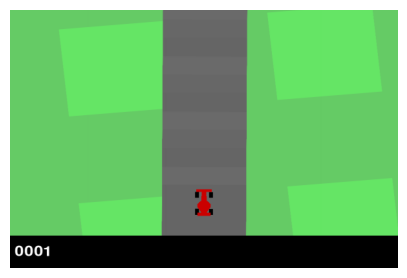

In [24]:
# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())